<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S3: Detección del cáncer

## Objetivos

Los objetivos de este challenge es hacer un modelo capaz de detectar el cáncer.

## Configuración del entorno

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import scikitplot as skplt
from sklearn.neighbors import KNeighborsClassifier

## Dataset

En este caso vamos a utilizar un dataset real de análisis de cáncer de mama del Breast Cancer Center de Wisconsin. Este dataset está disponible en `sklearn` así que cargarlo es tan fácil como:

In [2]:
from sklearn import datasets
dataset = sklearn.datasets.load_breast_cancer()

Como siempre, una vez cargado debemos inspeccionar y comprender el dataset:

In [3]:
print(dataset.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [4]:
print(dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Como se indica en la descripción del dataset, éste consta de 569 instancias con 30 atributos numéricos cada uno.

In [5]:
dataset_X = dataset.data

In [6]:
dataset_X.shape

(569, 30)

Este dataset clasifica los casos en cáncer maligno ($0$) o benigno ($1$).

In [7]:
print(dataset.target_names)

['malignant' 'benign']


In [8]:
dataset_y = dataset.target

In [9]:
dataset_y.shape

(569,)

In [10]:
print(dataset_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

In [11]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

In [12]:
def plot_2d_separator(classifier, X, y, fill=False, ax=None, eps=None):
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()

    ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black")

## ¿Este dataset está balanceado o desbalanceado?

El dataset está desbalanceado ya que podemos ver 212 casos malignos y 357 benignos.

In [13]:
np.bincount(dataset_y)

array([212, 357])

In [14]:
np.bincount(dataset.target)[0] / dataset.target.shape[0]

0.37258347978910367

El 37% de los casos son malignos y el 63% benignos. El dataset está un poco desbalanceado. Es un conjunto de datos bastante sesgado.

## ¿Cual sería el clasificador más sencillo con mejor % de acierto que se te ocurre? ¿es útil en la práctica?

El clasificador de clase más frecuente, con él tendríamos un porcentaje de acierto del 63%. No nos sería útil en la práctica ya que no nos daría ningún resultado maligno.

In [15]:
dc_most_frequent = DummyClassifier(strategy='most_frequent', random_state=None)

In [16]:
cross_val_score(dc_most_frequent, dataset_X, dataset_y, scoring="accuracy")

array([0.62631579, 0.62631579, 0.62962963])

## Entrena un modelo y evalúa su rendimiento

###### Dividimos el conjunto de entrenamiento

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

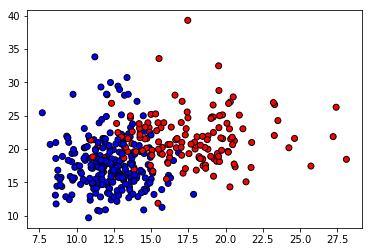

In [18]:
dibuja_dataset(X_train, y_train)

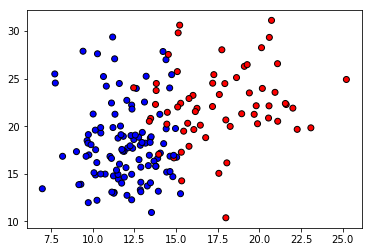

In [19]:
dibuja_dataset(X_test, y_test)

###### Entrenamos el modelo de clasificación

In [20]:
nn = KNeighborsClassifier()

In [21]:
nn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
print(nn.score(X_test, y_test))

0.9590643274853801


###### Valor de Accuracy

In [23]:
cross_val_score(nn, dataset_X, dataset_y, scoring="accuracy")

array([0.9       , 0.94736842, 0.92063492])

###### Valor de Recall

In [24]:
cross_val_score(nn, dataset_X, dataset_y, scoring="recall")

array([0.96638655, 0.96638655, 0.94117647])

In [25]:
np.mean(cross_val_score(nn, dataset_X, dataset_y, scoring="recall"))

0.957983193277311

## Dibuja la matriz de confusión

In [26]:
y_predicted = nn.predict(X_test)

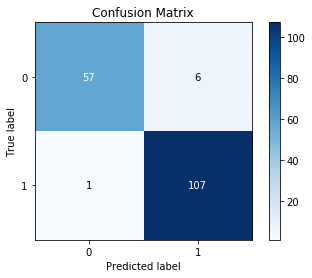

In [27]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_predicted)

## Si tengo un paciente con un cáncer benigno (1), ¿qué probabilidad hay de que el modelo lo clasifique como cáncer benigno (1)? 

Hay un 99% de probabilidades de que lo clasifique como cáncer benigno. Es decir, 107 de cada 108 casos los clasificará bien.

In [28]:
107 / 108

0.9907407407407407

## Si tengo un paciente con un cáncer maligno (0), ¿qué probabilidad hay de que el modelo lo clasifique como cáncer benigno (1)? 

Hay un 9.5% de probabilidades de que clasifique un cáncer maligno como benigno. Es decir, 6 de cada 63 casos los clasificará mal.

In [29]:
6 / (57 + 6)

0.09523809523809523

## Si tengo un paciente con un cáncer benigno (1), ¿qué probabilidad hay de que el modelo lo clasifique como cáncer maligno (0)? 

Hay un 1% de probabilidades de que lo clasifique como cáncer maligno. Es decir, 1 de cada 108 casos los clasificará mal.

In [30]:
1 / (107+1)

0.009259259259259259

## ¿Qué podrías concluir del clasificador?

El error está distribuido donde menos nos interesa tenerlo, ya que el número de Falsos Positivos es muy importante en este caso - le estamos diciendo a pacientes enfermos que no tienen cáncer, lo que es muy peligroso.

Por otro lado, si vemos el valor de recall es bastante alto; lo cual es positivo ya que para predicciones de este tipo nos interesa tener bien clasificados todos los positivos. Además, es un clasificador muy fácil de implementar y cuyo tiempo de cálculo es reducido, por lo que estaría bien para una primera resolución aproximada del problema. Sería interesante, para asegurarnos de que el resultado obtenido es bueno o malo, hablar con un oncólogo y analizar el número de falsos positivos que se dan en una consulta con más información de la que se tiene para este clasificador. 

## (extra) ¿Se te ocurre alguna manera de mejorarlo?

* Preprocesado de datos.
* Entrenar más el dataset con datos más variados.
* Que nos indique el % de probabilidad de tener o no tener cáncer.
* Mandar datos hacia el lado maligno en caso de dudas.
* Hiperparametrizar: estudiar distintos valores de K y ver cuál sería el más adecuado.
* Elegir modelos de clasificación más potentes.